In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime
from pprint import pprint
import ipdb

## Initial Data Viewing

In [33]:
surface_pos_data = pd.read_csv("data/LuGRE_surface_pos.csv")
print(f"Columns: {surface_pos_data.columns}")

Columns: Index(['rxTime', 'wn', 'tow', 'decimals', 'posX', 'posY', 'posZ'], dtype='object')


In [34]:
rx_time = surface_pos_data["rxTime"]
x_pos = surface_pos_data["posX"]
y_pos = surface_pos_data["posY"]
z_pos = surface_pos_data["posZ"]

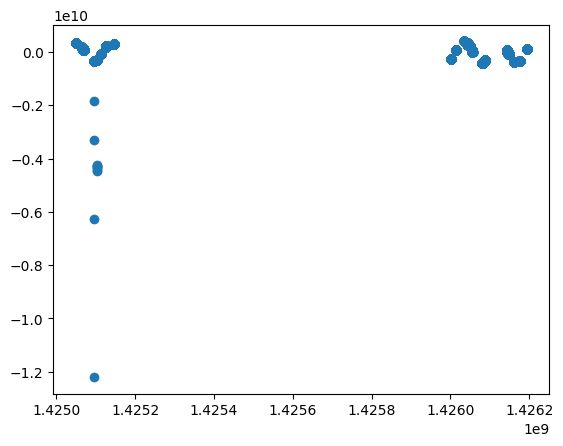

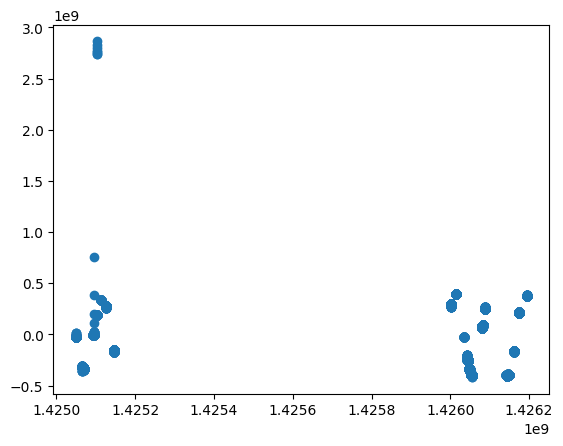

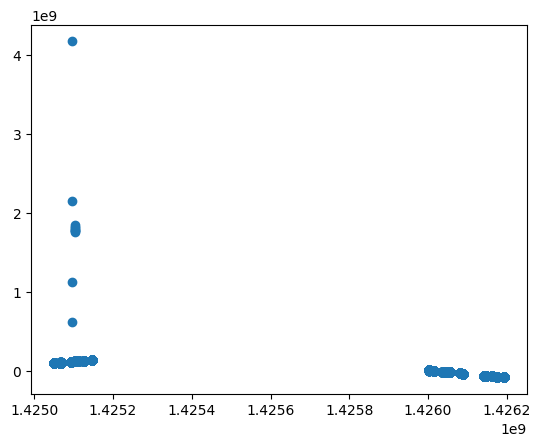

In [35]:
start = 4000
end = -2000

plt.scatter(rx_time[start:end], x_pos[start:end])
plt.show()
plt.scatter(rx_time[start:end], y_pos[start:end])
plt.show()
plt.scatter(rx_time[start:end], z_pos[start:end])
plt.show()

In [36]:
surface_pr_cn0_data = pd.read_csv("data/LuGRE_surface_pr_cn0.csv")
print(f"Columns: {surface_pr_cn0_data.columns}")

Columns: Index(['rxTime', 'svid', 'signalId', 'prRaw', 'cn0'], dtype='object')


In [37]:
rx_time = surface_pr_cn0_data["rxTime"]
svid = surface_pr_cn0_data["svid"]
signalId = surface_pr_cn0_data["signalId"]
prRaw = surface_pr_cn0_data["prRaw"]
cn0 = surface_pr_cn0_data["cn0"]


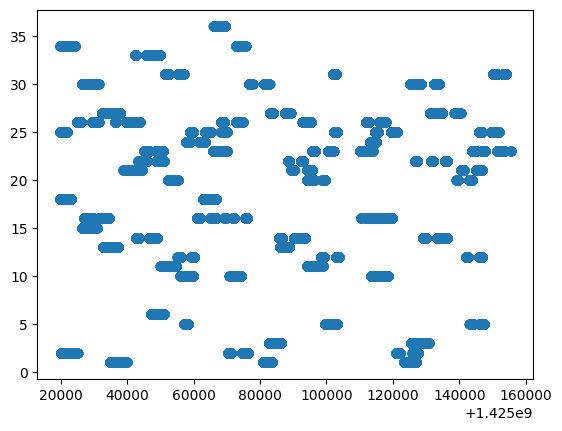

In [38]:
plt.scatter(rx_time[rx_time < 1.4252e9], svid[rx_time < 1.4252e9])

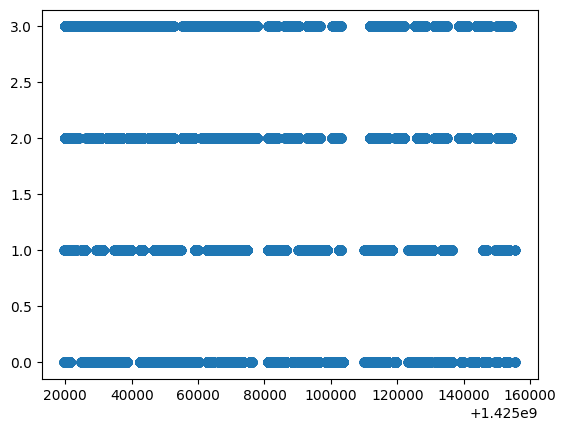

In [39]:
plt.scatter(rx_time[rx_time < 1.4252e9], signalId[rx_time < 1.4252e9])

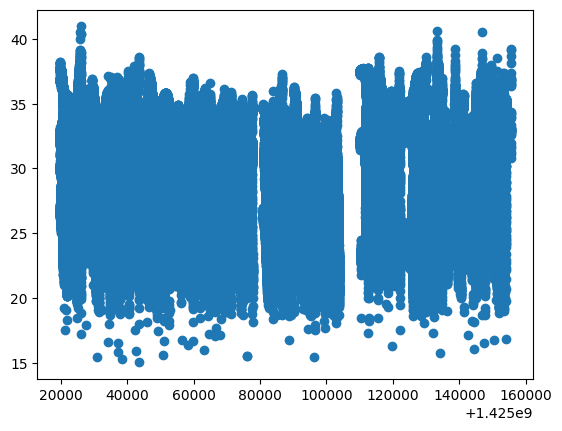

In [40]:
plt.scatter(rx_time[rx_time < 1.4252e9], cn0[rx_time < 1.4252e9])

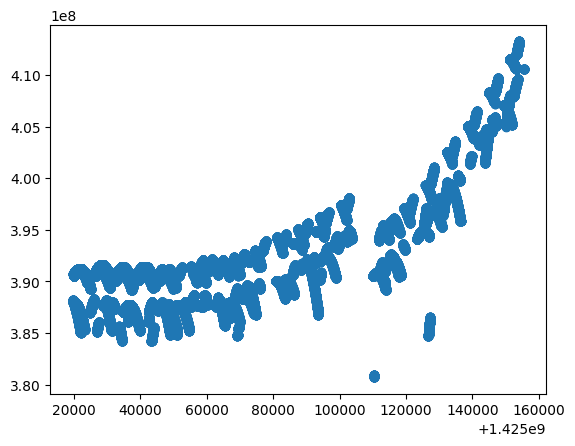

In [41]:
plt.scatter(rx_time[rx_time < 1.4252e9], prRaw[rx_time < 1.4252e9])

## Data Structures

In [42]:
class DataType(Enum):
    TLM_ACQ = 0
    TLM_NAV = 0
    TLM_RAW = 0
    TLM_CLK = 0
    TLM_EPH = 0

class SignalIdEnum(Enum):
    GPS_L1CA = 0
    GPS_L5 = 1
    GAL_E1BC = 2
    GAL_E5A = 3
    GAL_E5B = 4

class PhaseEnum(Enum):
    COMMISSIONING = 0
    TRANSIT = 1
    LOW_LUNAR_ORBIT = 2
    LUNAR_SURFACE = 3

letter_to_phase = {
    "C": PhaseEnum.COMMISSIONING,
    "T": PhaseEnum.TRANSIT,
    "L": PhaseEnum.LOW_LUNAR_ORBIT,
    "S": PhaseEnum.LUNAR_SURFACE
}

class OpModeEnum(Enum):
    RTP = 0 # Real-time Processing
    SC = 1 # Sample capture
    SC_RTP = 2
    RTP_SC = 3

class SC_BandsEnum(Enum):
    L1_E1 = 0 # GPS L1 / Galileo E1 Band
    L5_E5a = 1 # GPS L5 / Galileo E5a Band
    L1_E1_L5_E5a = 1 # Both


In [43]:
# Message Formats

@dataclass
class TLM_ACQ:
    rxTime_s: float
    signalId: SignalIdEnum
    svid: int
    doppler_Hz: float
    codePhase_chips: float
    noiseFloor: float
    acqMode: int
    cn0_dB_Hz: float
    acfCorr: list = field(default_factory=list)

@dataclass
class TLM_RAW_measurement:
    rxTime_s: float
    signalId: SignalIdEnum
    svid: int
    fdRaw_Hz: float
    fdRateRaw_Hz_s: float
    prRaw_m: float
    cn0_dB_Hz: float
    carrierPhase_m: float = -np.inf

@dataclass
class TLM_RAW:
    rxTime_s: float
    measurements: list = field(default_factory=list)

@dataclass
class TLM_NAV:
    rxTime_s: float
    appName: str
    wn: int
    tow_s: int
    decimals_s: float
    nSat: int
    posX_m: float
    posY_m: float
    posZ_m: float
    velX_m_s: float
    velY_m_s: float
    velZ_m_s: float
    posStd_m: float
    velStd_m_s: float
    timStd_m: float
    clockBias_m: float
    clockDrift_m_s: float
    ggto_m: float
    GDOP: float
    PDOP: float
    HDOP: float
    VDOP: float
    TDOP: float

@dataclass
class LuGRE_op:
    OP_ID: int
    Phase: PhaseEnum
    InitialAltitude_RE: float
    ReferenceOpStartTime: datetime
    Mode: OpModeEnum
    RTP_StartTime: datetime
    RTP_EndTime: datetime
    SC_StartTime: datetime
    SC_bands: SC_BandsEnum

    
    

In [44]:

@dataclass
class TLM_File:
    """Metadata for TLM Files"""
    filename: str
    start_time: datetime
    duration_hrs: int
    phase: PhaseEnum
    OP_num: int
    datatype: DataType
    data: list = field(default_factory=list)
    

## Import Functions

In [45]:
def get_metadata(filename: str):

    filename = filename.split("/")[-1]
    metadata = filename.split(".")[0].split("_")

    msg_time = datetime(
        year=int(metadata[2][0:4]),
        month=int(metadata[2][4:6]),
        day=int(metadata[2][6:8]),
        hour=int(metadata[3][0:2]),
        minute=int(metadata[3][2:4]),
        second=int(metadata[3][4:6])
        )
    duration = int(metadata[4].upper().strip("H"))
    phase = PhaseEnum(letter_to_phase[metadata[5]])
    op_num = (
        100 * int(metadata[6].strip("OP")) +
        int(metadata[7])
        )

    return msg_time,duration,phase,op_num

In [46]:
def line_to_TLM_RAW(line: str):

    rx_time_str = line.split(" measures: [")[0].split("rxTime: ")[1]
    rx_time = float(rx_time_str)

    measurements: list[TLM_RAW_measurement] = []
    
    measurement_strings = line.split("svid: ")[1:]
    for measurement in measurement_strings:
        fields = [value.split(" ")[0] for value in measurement.split(": ")]
        measurements.append(TLM_RAW_measurement(
            rxTime_s=rx_time,
            svid=int(fields[0]),
            prRaw_m=float(fields[1]),
            cn0_dB_Hz=float(fields[2]),
            signalId=int(fields[3]),
            fdRaw_Hz=float(fields[4]),
            fdRateRaw_Hz_s=float(fields[6])
        ))
        
    return TLM_RAW(
        rxTime_s=rx_time,
        measurements=measurements
    )

# result = line_to_TLM_RAW("senderId: 0 messageType: RAW rxTime: 1423541963.42022 measures: [ svid: 26 prRaw: 425488632.165556 cn0: 34.1078993053348 signalId: 3 fdRaw: 2815.65639510737 accDoppler: 425497878.197944 fdRateRaw: -0.116324794106927 svid: 26 prRaw: 425488616.822525 cn0: 31.3180286979497 signalId: 2 fdRaw: 3771.63520573088 accDoppler: 425491816.925568 fdRateRaw: 6.05262249423344 ]")
# pprint(result)

def load_TLM_RAW(filename: str):

    with open(filename, "r") as f:
        measurements = [line_to_TLM_RAW(line) for line in f.readlines()]

    return TLM_File(
        filename,
        *get_metadata(filename),
        datatype=DataType.TLM_RAW,
        data=measurements
    )

# tlm_raw = load_TLM_RAW("LuGRE Mission Data/L0/TLM/TLM_RAW_20250219_152027_01H_L_OP27_0.txt")
# pprint(tlm_raw.data[25])


In [47]:
def line_to_TLM_ACQ(line: str):

    return TLM_ACQ(
        rxTime_s = float(line.split(" signalId")[0].split("rxTime: ")[1]),
        signalId = int(line.split(" svid")[0].split("signalId: ")[1]),
        svid = int(line.split(" doppler")[0].split("svid: ")[1]),
        doppler_Hz = float(line.split(" codePhase")[0].split("doppler: ")[1]),
        codePhase_chips = float(line.split(" acfCorr")[0].split("codePhase: ")[1]),
        noiseFloor = float(line.split(" acqMode")[0].split("noiseFloor: ")[1]),
        acqMode = int(line.split(" CN0")[0].split("acqMode: ")[1]),
        cn0_dB_Hz = float(line.strip().split("CN0: ")[-1]),
        acfCorr = [int(i) for i in 
                line.split(" ] noiseFloor")[0].split("acfCorr: [ ")[1].split(" ")]
    )    
    


def load_TLM_ACQ(filename: str):

    with open(filename, "r") as f:
        measurements = [line_to_TLM_ACQ(line) for line in f.readlines()]

    return TLM_File(
        filename,
        *get_metadata(filename),
        datatype=DataType.TLM_ACQ,
        data=measurements
    )

# tlm_acq = load_TLM_ACQ("LuGRE Mission Data/L0/TLM/TLM_ACQ_20250117_022153_01H_T_OP3_0.txt")
# pprint(tlm_acq.data)

In [48]:
def line_to_TLM_NAV(line: str):
    
    return TLM_NAV(
        rxTime_s = float(line.split(" appName")[0].split("rxTime: ")[1]),
        appName = line.split(" wn")[0].split("appName: ")[1],
        wn = int(line.split(" tow")[0].split("wn: ")[1]),
        tow_s = int(line.split(" decimals")[0].split("tow: ")[1]),
        decimals_s = float(line.split(" nSat")[0].split("decimals: ")[1]),
        nSat = int(line.split(" posX")[0].split("nSat: ")[1]),
        posX_m = float(line.split(" posY")[0].split("posX: ")[1]),
        posY_m = float(line.split(" posZ")[0].split("posY: ")[1]),
        posZ_m = float(line.split(" velX")[0].split("posZ: ")[1]),
        velX_m_s = float(line.split(" velY")[0].split("velX: ")[1]),
        velY_m_s = float(line.split(" velZ")[0].split("velY: ")[1]),
        velZ_m_s = float(line.split(" posStd")[0].split("velZ: ")[1]),
        posStd_m = float(line.split(" velStd")[0].split("posStd: ")[1]),
        velStd_m_s = float(line.split(" timStd")[0].split("velStd: ")[1]),
        timStd_m = float(line.split(" clockBias")[0].split("timStd: ")[1]),
        clockBias_m = float(line.split(" clockDrift")[0].split("clockBias: ")[1]),
        clockDrift_m_s = float(line.split(" ggto")[0].split("clockDrift: ")[1]),
        ggto_m = float(line.split(" GDOP")[0].split("ggto: ")[1]),
        GDOP = float(line.split(" PDOP")[0].split("GDOP: ")[1]),
        PDOP = float(line.split(" HDOP")[0].split("PDOP: ")[1]),
        HDOP = float(line.split(" VDOP")[0].split("HDOP: ")[1]),
        VDOP = float(line.split(" TDOP")[0].split("VDOP: ")[1]),
        TDOP = float(line.strip().split(" TDOP: ")[-1])
    )    

def load_TLM_NAV(filename: str):

    with open(filename, "r") as f:
        measurements = [line_to_TLM_NAV(line) for line in f.readlines()]

    return TLM_File(
        filename,
        *get_metadata(filename),
        datatype=DataType.TLM_NAV,
        data=measurements
    )

# tlm_nav = load_TLM_NAV("LuGRE Mission Data/L0/TLM/TLM_NAV_20250115_152133_01H_C_OP1_0.txt")
# pprint(tlm_nav)

## 

## Actually Importing Data

In [135]:
# This will take like 7 seconds to run

tlm_dir = "LuGRE Mission Data/L0/TLM/"
files = os.listdir(tlm_dir)




def is_before_op(file: str, op: int):
    _,_,_,file_op = get_metadata(file.strip())
    file_op //= 100 # Get actual OP instead of OP number representation
    return file_op < op

In [140]:
nav_filenames = sorted([f for f in files if (
    "NAV" in f and 
    not is_before_op(f, 38)
    and ".bin" not in f)])
# acq_filenames = sorted([f for f in files if ("ACQ" in f and not is_before_op(f, 38))])
# raw_filenames = sorted([f for f in files if ("RAW" in f and not is_before_op(f, 38))])


pprint([f"{i}:    {name}" for i,name in enumerate(nav_filenames)])


['0:    TLM_NAV_20250303_061243_24H_S_OP38_0.txt',
 '1:    TLM_NAV_20250304_070305_14H_S_OP40_0.txt',
 '2:    TLM_NAV_20250314_124700_24H_S_OP74_0.txt',
 '3:    TLM_NAV_20250315_130709_26H_S_OP76_0.txt',
 '4:    TLM_NAV_20250316_151215_03H_S_OP77_0.txt',
 '5:    TLM_NAV_20250316_191448_03H_S_OP77_1.txt',
 '6:    TLM_NAV_20250316_221113_01H_S_OP78_1.txt']


In [145]:
nav_files = [load_TLM_NAV(tlm_dir + f) for f in nav_filenames]
# acq_files = [load_TLM_ACQ(tlm_dir + f) for f in acq_filenames if ".bin" not in f]
# raw_files = [load_TLM_RAW(tlm_dir + f) for f in raw_filenames if ".bin" not in f]

## Exporting Data to CSV

In [146]:
# pprint(str(file.__dict__["phase"]).split(".")[-1].lower())
# pprint(file.data[0].__dict__)

def make_df(files: list[TLM_File], column_order: list[str]):

    df = pd.DataFrame()
    num_files = len(files)

    for i, file in enumerate(files):
        file_attributes = file.__dict__
        for measurement in file.data:
            row: dict = measurement.__dict__ | file_attributes
            row.pop("data")
            df = pd.concat([df, pd.DataFrame.from_dict([row])], ignore_index=True)

        print(f"Processed {i+1}/{num_files} files ({file.filename})")


    return df[column_order]


In [147]:
# acq_df = make_df(acq_files, ["start_time", "duration_hrs", "phase", "OP_num", "datatype", "rxTime_s", "signalId", "svid", "doppler_Hz", "codePhase_chips", "noiseFloor", "acqMode", "cn0_dB_Hz", "acfCorr"])
nav_df = make_df(nav_files, ["start_time", "duration_hrs", "phase", "OP_num", "datatype", "rxTime_s", "appName", "wn", "tow_s", "decimals_s", "nSat", "posX_m", "posY_m", "posZ_m", "velX_m_s", "velY_m_s", "velZ_m_s", "posStd_m", "velStd_m_s", "timStd_m", "clockBias_m", "clockDrift_m_s", "ggto_m", "GDOP", "PDOP", "HDOP", "VDOP", "TDOP"])
# raw_df = make_df(raw_files, ["start_time", "duration_hrs", "phase", "OP_num", "datatype", "rxTime_s", "signalId", "svid", "doppler_Hz", "codePhase_chips", "noiseFloor", "acqMode", "cn0_dB_Hz", "acfCorr"])

Processed 1/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250303_061243_24H_S_OP38_0.txt)
Processed 2/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250304_070305_14H_S_OP40_0.txt)
Processed 3/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250314_124700_24H_S_OP74_0.txt)
Processed 4/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250315_130709_26H_S_OP76_0.txt)
Processed 5/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250316_151215_03H_S_OP77_0.txt)
Processed 6/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250316_191448_03H_S_OP77_1.txt)
Processed 7/7 files (LuGRE Mission Data/L0/TLM/TLM_NAV_20250316_221113_01H_S_OP78_1.txt)


In [148]:
def save_as_csv(df: pd.DataFrame, filename: str):
    with open(filename, "w") as f:
        f.write(df.to_csv())

# save_as_csv(acq_df, "data/ALL_TLM_ACQ.csv")
save_as_csv(nav_df, "data/ALL_TLM_NAV.csv")

In [149]:
print(nav_df["rxTime_s"])

0        1.425020e+09
1        1.425020e+09
2        1.425020e+09
3        1.425020e+09
4        1.425020e+09
             ...     
18517    1.426201e+09
18518    1.426201e+09
18519    1.426201e+09
18520    1.426201e+09
18521    1.426201e+09
Name: rxTime_s, Length: 18522, dtype: float64


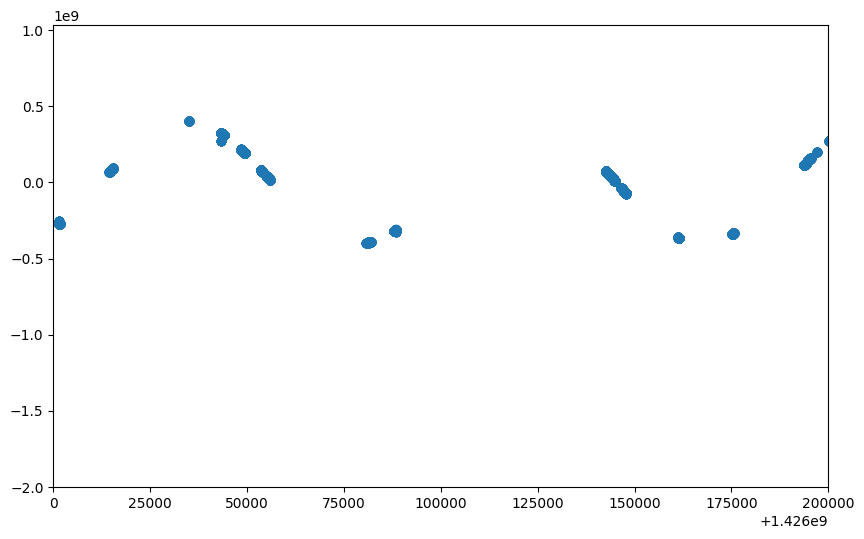

In [154]:
n = len(nav_df["start_time"])

plt.figure(figsize=(10,6))
plt.scatter(nav_df["rxTime_s"], nav_df["posX_m"])
plt.xlim(1.4260e9, 1.4262e9)
plt.ylim(bottom= -0.2e10)
plt.show()


# plt.scatter(nav_df["start_time"][start:end], nav_df["posY_m"][start:end])
# plt.show()
# plt.scatter(nav_df["start_time"][start:end], nav_df["posZ_m"][start:end])
# plt.show()

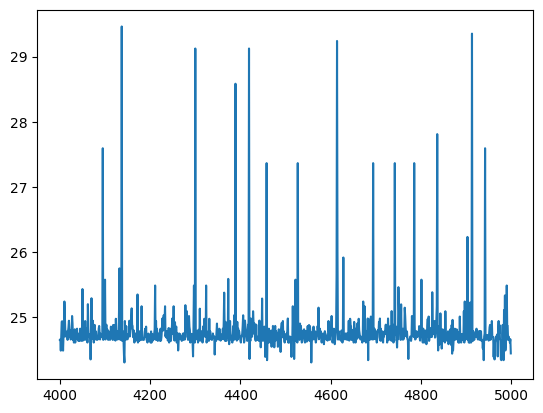

In [60]:
start = 4000
end = -4000

plt.plot(acq_df["cn0_dB_Hz"][start:start+1000])
plt.show()
# plt.plot(acq_df["posY_m"][start:end])
# plt.show()
# plt.plot(acq_df["posZ_m"][start:end])
# plt.show()